# Panel Fixed Effects (PyMC)

{term}`Panel data` lets us follow the same units over time. Fixed effects regression
controls for time-invariant unit heterogeneity by estimating unit-specific intercepts
(dummy variables) or by using the within transformation (demeaning).

We introduce `PanelRegression`, compare dummy-variable and within estimators, and
connect the approach to Difference-in-Differences ({doc}notebooks/did_pymc).

Key ideas:
- unit fixed effects remove time-invariant confounding
- within transformation avoids large dummy matrices
- two-way fixed effects add time indicators for common shocks

:::{note}
This notebook uses small sampling settings for quick execution.
:::


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

import causalpy as cp

## Outline

1. Intuition and within transformation
2. Simulated example (ground truth)
3. Small panel with unit effects (dummy FE)
4. Large panel with within transformation
5. Two-way fixed effects and diagnostics
6. Exercises


## Intuition: fixed effects and demeaning

A standard unit fixed effects model is:

$y_{it} = \alpha_i + \lambda_t + \beta D_{it} + X_{it}\gamma + \varepsilon_{it}$

- $\alpha_i$ captures time-invariant unit characteristics
- $\lambda_t$ captures time shocks common to all units
- $D_{it}$ is a treatment indicator

The within transformation subtracts unit means:

$\tilde{y}_{it} = y_{it} - \bar{y}_i$, and similarly for $D_{it}$ and $X_{it}$.

This removes $\alpha_i$ and lets us estimate $\beta$ without creating dummy variables.
For two-way fixed effects, we also demean by time.

For a deeper econometric treatment, see {cite:t}`cunningham2021causal`.


## Simulated panel data

We simulate a balanced panel with unit effects, time effects, and a treatment effect.
The goal is to recover the treatment effect while accounting for unit heterogeneity.


In [2]:
rng = np.random.default_rng(42)

n_units = 30
n_periods = 8
units = np.repeat(np.arange(n_units), n_periods)
times = np.tile(np.arange(n_periods), n_units)

unit_effects = rng.normal(0, 1.0, n_units)
time_effects = rng.normal(0, 0.5, n_periods)

x = rng.normal(0, 1.0, n_units * n_periods)
treatment = rng.binomial(1, 0.4, n_units * n_periods)
true_effect = 1.5

noise = rng.normal(0, 0.5, n_units * n_periods)

y = (
    unit_effects[units]
    + time_effects[times]
    + true_effect * treatment
    + 0.5 * x
    + noise
)

panel_df = pd.DataFrame(
    {
        "unit": units,
        "time": times,
        "x": x,
        "treatment": treatment,
        "y": y,
    }
)

panel_df.head()

,unit,time,x,treatment,y
0,0,0,-0.824481,1,2.695840
1,0,1,0.650593,0,-0.353673
2,0,2,0.743254,1,1.771561
3,0,3,0.543154,0,0.219147
4,0,4,-0.665510,1,1.736902


In [3]:
def summarize_treatment(result, term="treatment", hdi_prob=0.9):
    labels = result.labels
    if term not in labels:
        raise ValueError(f"{term} not found in model labels")
    coef_index = labels.index(term)
    if isinstance(result.model, cp.pymc_models.PyMCModel):
        coeffs = az.extract(result.model.idata.posterior, var_names="beta")
        coeffs = coeffs.sel(treated_units=coeffs.coords["treated_units"].values[0])
        term_draws = coeffs.sel(coeffs=term)
        hdi = az.hdi(term_draws, hdi_prob=hdi_prob)
        return {
            "mean": float(term_draws.mean("sample")),
            "hdi_low": float(hdi.sel(hdi="lower")),
            "hdi_high": float(hdi.sel(hdi="higher")),
        }
    return {"mean": float(result.model.get_coeffs()[coef_index])}

## Dummy-variable fixed effects

Include unit and time indicators directly in the formula. This is straightforward and
lets us inspect unit-specific coefficients.


In [5]:
dummies_model = cp.pymc_models.LinearRegression(
    sample_kwargs={
        "chains": 2,
        "draws": 200,
        "tune": 200,
        "target_accept": 0.9,
        "progressbar": False,
        "random_seed": 42,
    }
)

result_dummies = cp.PanelRegression(
    data=panel_df,
    formula="y ~ C(unit) + C(time) + treatment + x",
    unit_fe_variable="unit",
    time_fe_variable="time",
    fe_method="dummies",
    model=dummies_model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 2 chains for 200 tune and 200 draw iterations (400 + 400 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [6]:
result_dummies.summary()

================================Panel Regression================================
Formula: y ~ C(unit) + C(time) + treatment + x
Units: 30 (unit)
Periods: 8 (time)
FE method: dummies
Model coefficients:
    Intercept      1.3, 94% HDI [0.98, 1.8]
    C(unit)[T.1]   -1.2, 94% HDI [-1.7, -0.77]
    C(unit)[T.2]   0.5, 94% HDI [-0.018, 1]
    C(unit)[T.3]   0.35, 94% HDI [-0.12, 0.77]
    C(unit)[T.4]   -2.4, 94% HDI [-2.9, -1.9]
    C(unit)[T.5]   -1.5, 94% HDI [-2, -1]
    C(unit)[T.6]   -0.37, 94% HDI [-0.8, 0.042]
    C(unit)[T.7]   -0.69, 94% HDI [-1.2, -0.27]
    C(unit)[T.8]   -0.46, 94% HDI [-0.93, -0.0019]
    C(unit)[T.9]   -1.3, 94% HDI [-1.7, -0.77]
    C(unit)[T.10]  0.5, 94% HDI [0.077, 0.92]
    C(unit)[T.11]  0.39, 94% HDI [-0.062, 0.82]
    C(unit)[T.12]  -0.34, 94% HDI [-0.77, 0.083]
    C(unit)[T.13]  0.79, 94% HDI [0.31, 1.2]
    C(unit)[T.14]  0.11, 94% HDI [-0.38, 0.57]
    C(unit)[T.15]  -1.3, 94% HDI [-1.8, -0.8]
    C(unit)[T.16]  0.12, 94% HDI [-0.36, 0.58]
    C(

## Within transformation

The within estimator demeans the data by unit (and time, if provided), which avoids
creating large dummy matrices. This is preferred for large panels.


In [7]:
within_model = cp.pymc_models.LinearRegression(
    sample_kwargs={
        "chains": 2,
        "draws": 200,
        "tune": 200,
        "target_accept": 0.9,
        "progressbar": False,
        "random_seed": 42,
    }
)

result_within = cp.PanelRegression(
    data=panel_df,
    formula="y ~ treatment + x",
    unit_fe_variable="unit",
    time_fe_variable="time",
    fe_method="within",
    model=within_model,
)

/Users/benjamv/git/CausalPy/causalpy/experiments/panel_regression.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.25  -0.75   0.25  -0.75   0.25   0.25   0.25   0.25   0.5    0.5
  0.5   -0.5   -0.5   -0.5    0.5   -0.5   -0.125  0.875 -0.125 -0.125
 -0.125 -0.125 -0.125 -0.125 -0.375 -0.375 -0.375  0.625 -0.375  0.625
  0.625 -0.375 -0.5   -0.5    0.5    0.5    0.5   -0.5    0.5   -0.5
  0.375 -0.625  0.375  0.375 -0.625  0.375 -0.625  0.375 -0.625  0.375
 -0.625  0.375  0.375 -0.625  0.375  0.375  0.75  -0.25  -0.25  -0.25
  0.75  -0.25  -0.25  -0.25  -0.375 -0.375  0.625  0.625 -0.375 -0.375
  0.625 -0.375 -0.5   -0.5    0.5   -0.5    0.5    0.5   -0.5    0.5
  0.75  -0.25  -0.25  -0.25  -0.25  -0.25   0.75  -0.25  -0.5    0.5
 -0.5    0.5    0.5   -0.5   -0.5    0.5    0.375  0.375 -0.625  0.375
  0.375 -0.625 -0.625  0.375 -0.25  -0.25   0.75  -0.25  -0.25  -0.25
 -0.25   0.75   0.375 -0.625  0.375  

In [8]:
result_within.summary()

================================Panel Regression================================
Formula: y ~ treatment + x
Units: 30 (unit)
Periods: 8 (time)
FE method: within
Model coefficients:
    Intercept    0.00086, 94% HDI [-0.051, 0.056]
    treatment    1.6, 94% HDI [1.4, 1.7]
    x            0.46, 94% HDI [0.39, 0.54]
    y_hat_sigma  0.49, 94% HDI [0.44, 0.53]


### Compare treatment estimates

Both approaches should recover the true treatment effect on this simulated panel.


In [9]:
summary_dummies = summarize_treatment(result_dummies)
summary_within = summarize_treatment(result_within)

pd.DataFrame(
    {
        "method": ["dummies", "within"],
        "estimate": [summary_dummies["mean"], summary_within["mean"]],
        "true_effect": [true_effect, true_effect],
    }
)

ValueError: Missing core dims {'draw', 'chain'} from arg number 1 on a variable named `beta`:
<xarray.Variable (sample: 400)> Size: 3kB
array([1.57057215, 1.57013218, 1.52397914, 1.67220542, 1.57199663,
       1.48858332, 1.62414239, 1.59612805, 1.61941031, 1.48311572,
       1.55409155, 1.46225304, 1.62853793, 1.57174023, 1.45981961,
       1.43797817, 1.5725262 , 1.41007586, 1.56005522, 1.53150886,
       1.59106391, 1.69238209, 1.39518096, 1.50074308, 1.48426758,
       1.43338129, 1.43542312, 1.52337746, 1.59527211, 1.49224427,
       1.51853794, 1.46921417, 1.42001541, 1.58278358, 1.56137972,
       1.46111782, 1.66690219, 1.48422342, 1.5322973 , 1.37511373,
       1.57748691, 1.60392727, 1.53395418, 1.54547357, 1.48840353,
       1.58540911, 1.53923651, 1.57491693, 1.59193645, 1.52111579,
       1.59377557, 1.62198151, 1.66375968, 1.46400664, 1.45485061,
       1.43789605, 1.45574952, 1.61556478, 1.59524657, 1.38420266,
       1.70899059, 1.42747921, 1.49855039, 1.38782131, 1.68140838,
       1.41037593, 1.48943489, 1.58421277, 1.49547401, 1.52629381,
       1.49427581, 1.48369737, 1.60442436, 1.59686808, 1.5381013 ,
       1.54890706, 1.54965856, 1.49708358, 1.62404463, 1.3780108 ,
       1.48835817, 1.57392344, 1.54192886, 1.41337148, 1.63429138,
       1.47031386, 1.65535277, 1.67847077, 1.65838085, 1.4156537 ,
       1.55772195, 1.63980256, 1.45861128, 1.4992685 , 1.60196989,
       1.42584673, 1.61286327, 1.47843439, 1.60812938, 1.47062599,
...
       1.76378304, 1.64922437, 1.63165842, 1.47822201, 1.53074654,
       1.52156593, 1.52512897, 1.5010676 , 1.54789963, 1.59020171,
       1.64428639, 1.61091733, 1.61284562, 1.66452212, 1.654388  ,
       1.53417463, 1.64731081, 1.52761996, 1.61387681, 1.52253089,
       1.48851225, 1.63399815, 1.6604335 , 1.46039995, 1.45842661,
       1.58134379, 1.55929596, 1.4343112 , 1.65302568, 1.59766103,
       1.42344278, 1.62788841, 1.38784288, 1.61464037, 1.42898617,
       1.64803652, 1.49073468, 1.52276313, 1.54301403, 1.6472306 ,
       1.52846837, 1.57455907, 1.53535044, 1.43081709, 1.40448809,
       1.58335175, 1.49761928, 1.55852081, 1.48032396, 1.60981521,
       1.50565241, 1.57240499, 1.59260127, 1.52788097, 1.53215695,
       1.64507772, 1.56609488, 1.55847735, 1.52242583, 1.53433524,
       1.48969664, 1.52673094, 1.50636654, 1.59744064, 1.62539462,
       1.64019703, 1.63113337, 1.49389279, 1.51469643, 1.52467834,
       1.5790893 , 1.53029313, 1.49987184, 1.62556222, 1.56224888,
       1.59643249, 1.45708277, 1.61014969, 1.45347358, 1.50218775,
       1.55363609, 1.58426462, 1.65154348, 1.45866231, 1.57601384,
       1.51058246, 1.52644452, 1.50569851, 1.63158278, 1.43491539,
       1.56778054, 1.59536179, 1.46522363, 1.60167736, 1.55641865,
       1.47188592, 1.56245121, 1.56644924, 1.53612121, 1.55229765])

Either add the core dimension, or if passing a dataset alternatively pass `on_missing_core_dim` as `copy` or `drop`. 

## Example: small panel with unit effects (dummy FE)

For smaller panels, dummy variables are practical and give unit-specific effects.
Here we simulate a "states × years" panel and use an OLS model for speed.


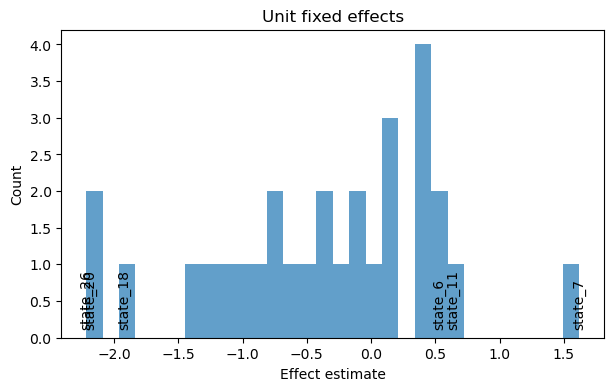

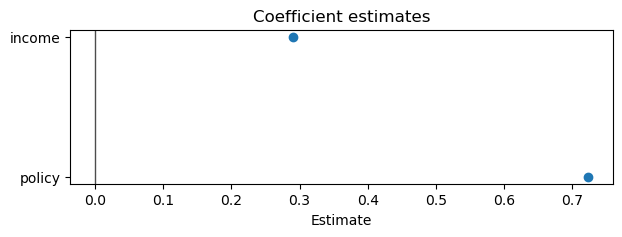

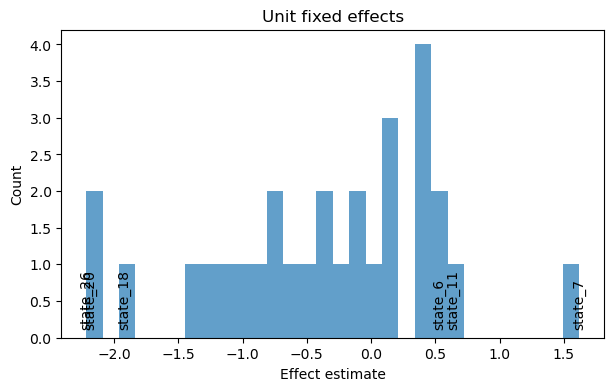

In [10]:
rng = np.random.default_rng(7)

n_states = 30
n_years = 10
states = np.repeat([f"state_{i}" for i in range(n_states)], n_years)
years = np.tile(np.arange(2000, 2000 + n_years), n_states)

state_effects = rng.normal(0, 1.0, n_states)
year_effects = rng.normal(0, 0.3, n_years)

policy = rng.binomial(1, 0.4, n_states * n_years)
income = rng.normal(0, 1.0, n_states * n_years)

small_df = pd.DataFrame(
    {
        "state": states,
        "year": years,
        "policy": policy,
        "income": income,
        "y": (
            state_effects[[int(s.split("_")[1]) for s in states]]
            + year_effects[years - 2000]
            + 0.8 * policy
            + 0.3 * income
            + rng.normal(0, 0.5, n_states * n_years)
        ),
    }
)

small_result = cp.PanelRegression(
    data=small_df,
    formula="y ~ C(state) + C(year) + policy + income",
    unit_fe_variable="state",
    time_fe_variable="year",
    fe_method="dummies",
    model=LinearRegression(),
)

small_result.plot_coefficients(var_names=["policy", "income"])
small_result.plot_unit_effects(label_extreme=3)

## Example: large panel with within transformation

For large panels, the within estimator avoids creating thousands of dummy columns.
We use an OLS model here to keep computation fast.


/Users/benjamv/git/CausalPy/causalpy/experiments/panel_regression.py:146: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.2  0.8 -0.2 ... -0.2 -0.2 -0.2]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, numeric_cols] = data[numeric_cols].sub(group_means)


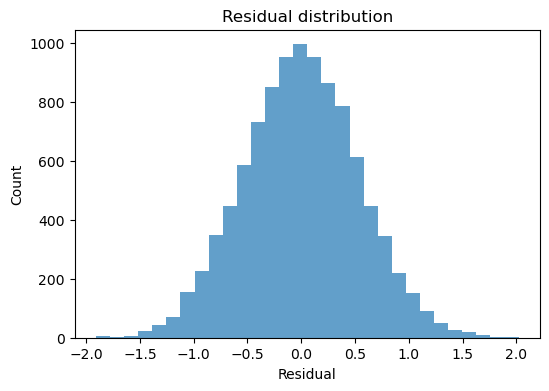

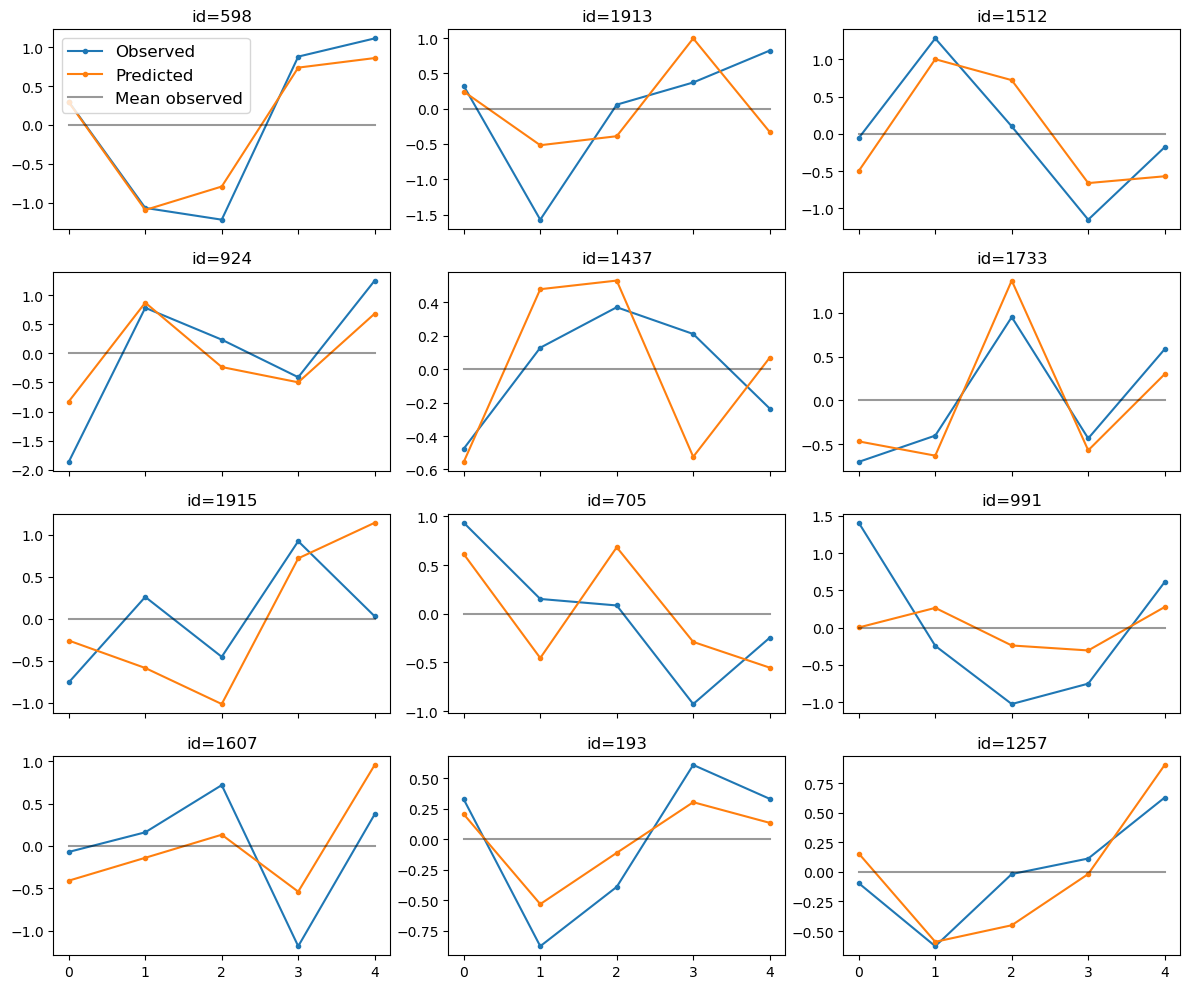

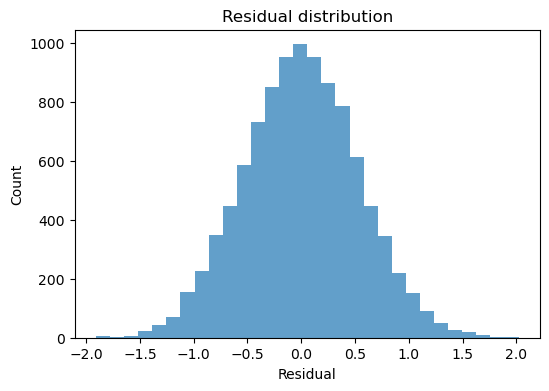

In [ ]:
rng = np.random.default_rng(21)

n_units_large = 2000
n_periods_large = 5
units_large = np.repeat(np.arange(n_units_large), n_periods_large)
times_large = np.tile(np.arange(n_periods_large), n_units_large)

unit_effects_large = rng.normal(0, 1.0, n_units_large)
time_effects_large = rng.normal(0, 0.2, n_periods_large)

x_large = rng.normal(0, 1.0, n_units_large * n_periods_large)
treatment_large = rng.binomial(1, 0.3, n_units_large * n_periods_large)

large_df = pd.DataFrame(
    {
        "id": units_large,
        "time": times_large,
        "x": x_large,
        "treatment": treatment_large,
        "y": (
            unit_effects_large[units_large]
            + time_effects_large[times_large]
            + 1.2 * treatment_large
            + 0.4 * x_large
            + rng.normal(0, 0.6, n_units_large * n_periods_large)
        ),
    }
)

large_result = cp.PanelRegression(
    data=large_df,
    formula="y ~ treatment + x",
    unit_fe_variable="id",
    time_fe_variable="time",
    fe_method="within",
    model=LinearRegression(),
)

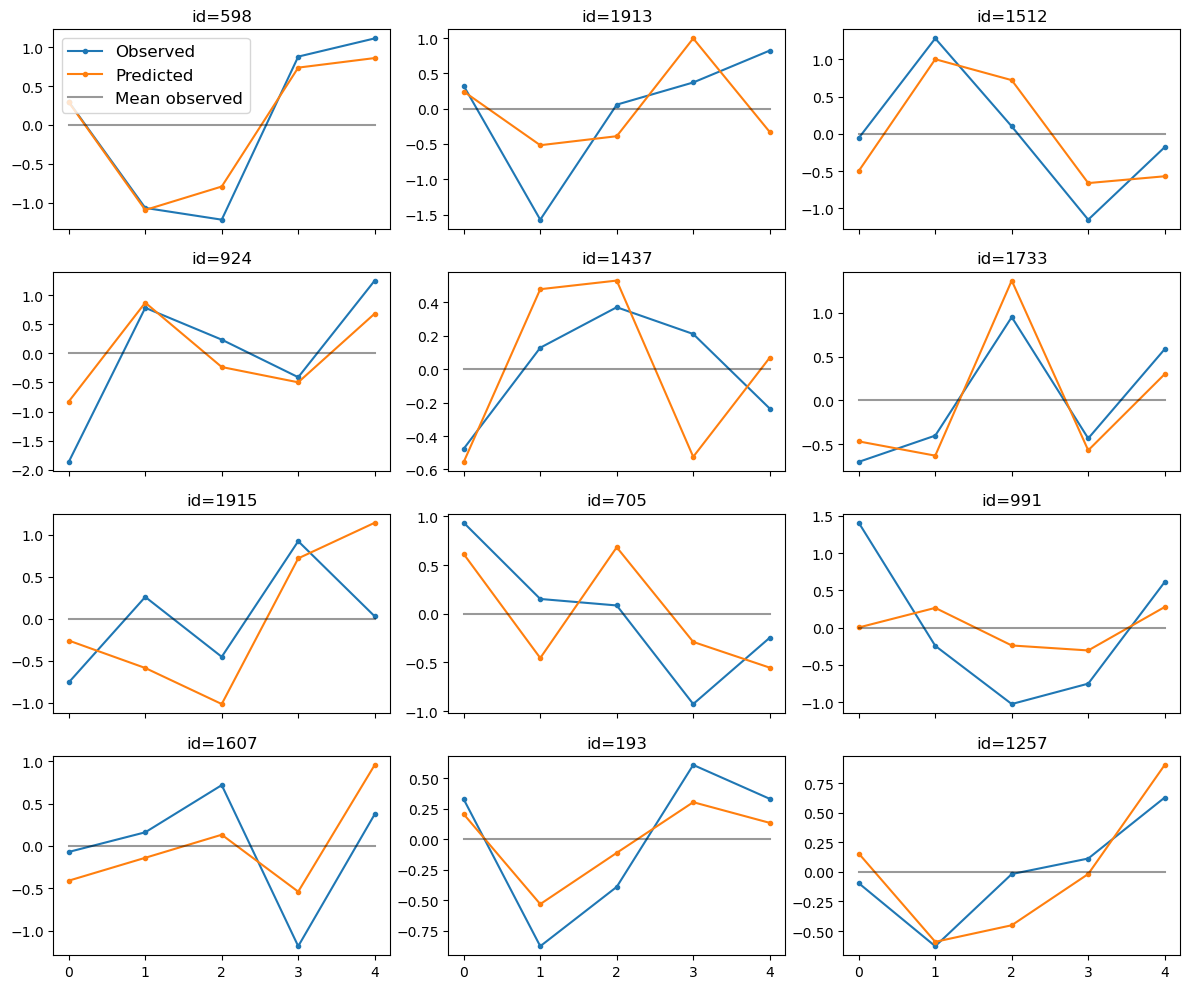

In [15]:
large_result.plot_trajectories(n_sample=12, select="random");

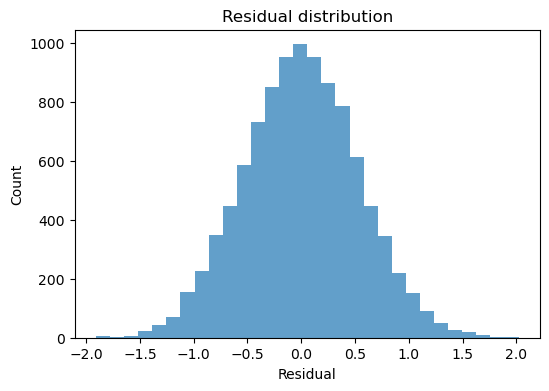

In [14]:
large_result.plot_residuals(kind="histogram");

## Diagnostics and visualization

The plotting helpers focus on covariate coefficients, unit effects (for dummy models),
trajectory subsets, and residual diagnostics. For large panels, the plotting methods
sample units automatically.

:::{note}
Within-transformed models plot demeaned outcomes and predictions.
:::


ValueError: Missing core dims {'draw', 'chain'} from arg number 1 on a variable named `beta`:
<xarray.Variable (coeffs: 3, sample: 400)> Size: 10kB
array([[1.0620972 , 1.07823805, 1.06763979, ..., 1.52455217, 1.59538179,
        1.63559953],
       [1.57057215, 1.57013218, 1.52397914, ..., 1.56644924, 1.53612121,
        1.55229765],
       [0.49783233, 0.47749703, 0.45853052, ..., 0.47983782, 0.45401651,
        0.49046701]], shape=(3, 400))

Either add the core dimension, or if passing a dataset alternatively pass `on_missing_core_dim` as `copy` or `drop`. 

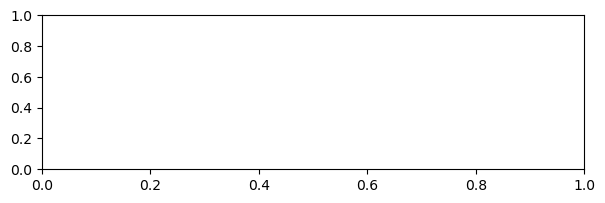

In [16]:
result_dummies.plot_coefficients()

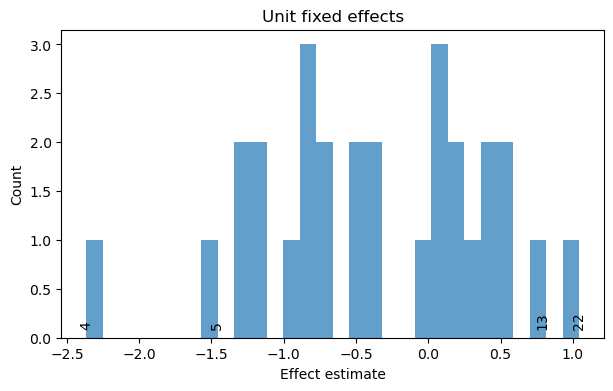

In [18]:
result_dummies.plot_unit_effects(label_extreme=2);

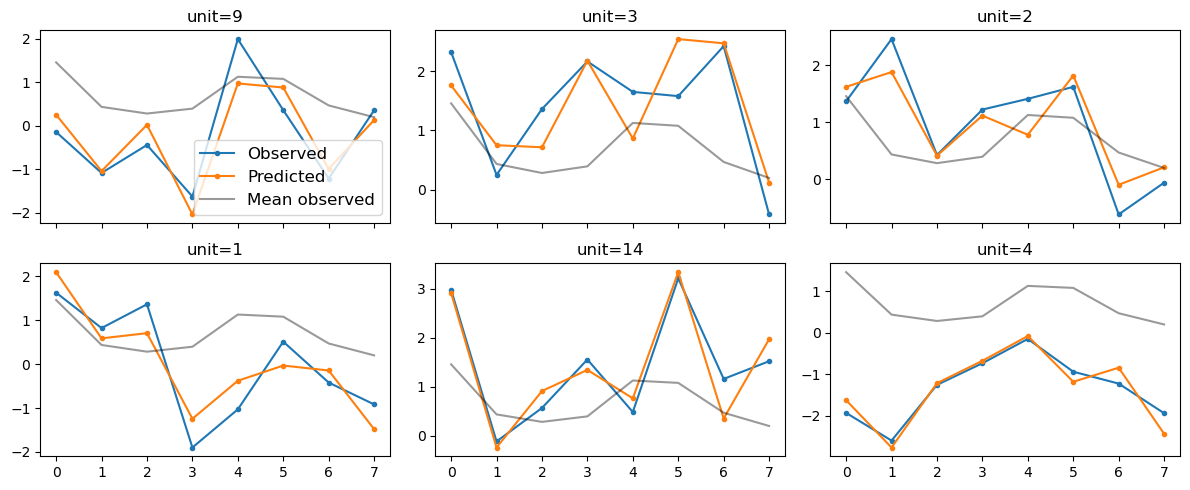

In [19]:
result_dummies.plot_trajectories(n_sample=6, select="random");

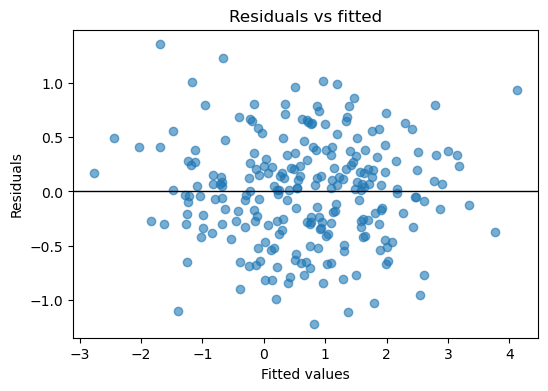

In [20]:
result_dummies.plot_residuals(kind="scatter");

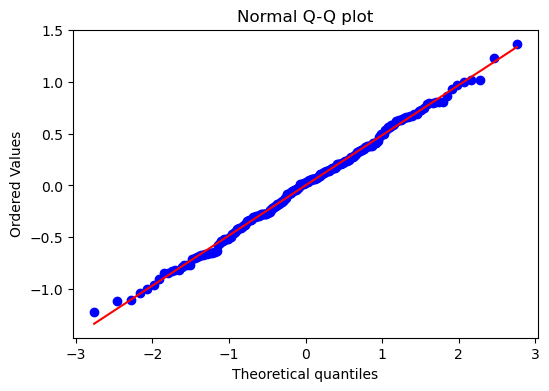

In [23]:
result_dummies.plot_residuals(kind="qq");

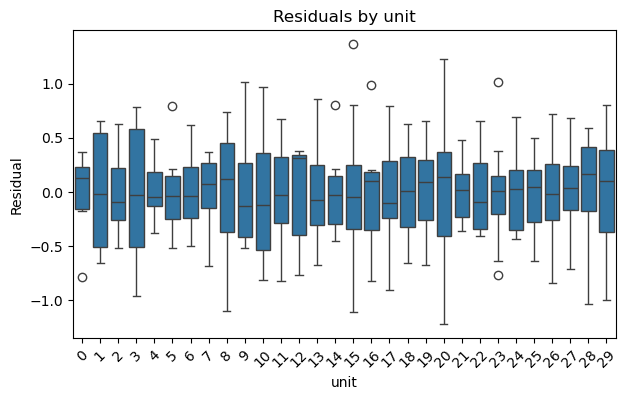

In [ ]:
result_dummies.plot_residuals(by="unit");

## Two-way fixed effects

Setting `time_fe_variable` applies time fixed effects alongside unit effects. This is
closely related to two-way fixed effects models used in Difference-in-Differences
settings ({doc}notebooks/did_pymc) and relies on the {term}`parallel trends assumption`.

For panel data foundations, see :footcite:p:`cunningham2021causal`.


## Comparison to random effects

Random effects models assume unit effects are uncorrelated with covariates. Fixed
effects relax that assumption by conditioning on unit-specific intercepts, but do not
estimate time-invariant covariates. In practice, FE is preferred when unit effects are
likely correlated with treatment or controls.

## Exercises

- Drop the time fixed effects and compare the treatment estimate.
- Increase unit heterogeneity and compare dummy vs within estimates.
- Use `plot_trajectories(select="extreme")` and inspect the units selected.


## References

:::{bibliography}
:filter: docname in docnames
:::
